# Purpose of Notebook
This Notebook is the setup for our research paper "Auditing Chain-of-Thought Reasoning via Perturbation-Based Attribution". 
We will be doing the following:
1. Load LLM
2. Use Bits and Bytes for efficient processing
3. Load Captum Library
4. Load GSM8K data set
5. Break question into phrases
6. Generate solution + extract solution steps + heatmap of phrase attribution per step
7. Use ground truth and attribution map to decide if steps were faithful or not
8. Visualze the results

## Starting Instructions
### 1. Use a GPU for attribution score generation as shown in the image before starting
2. 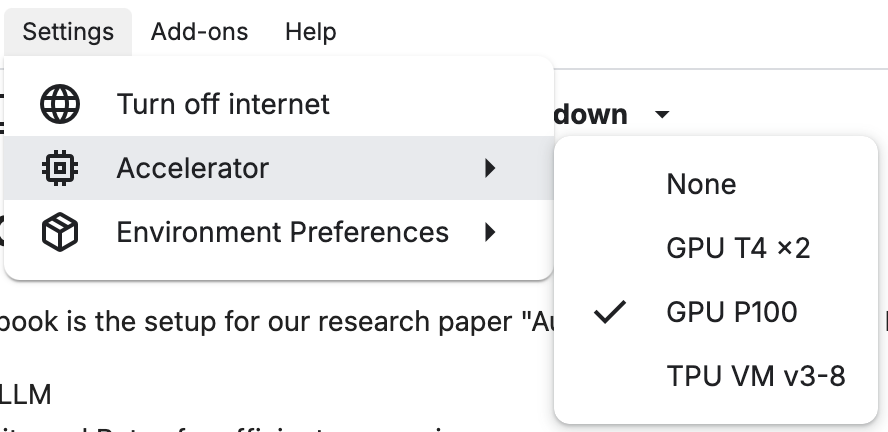
### 2. The first cell will clean Up the cache left from any previous runs
3. 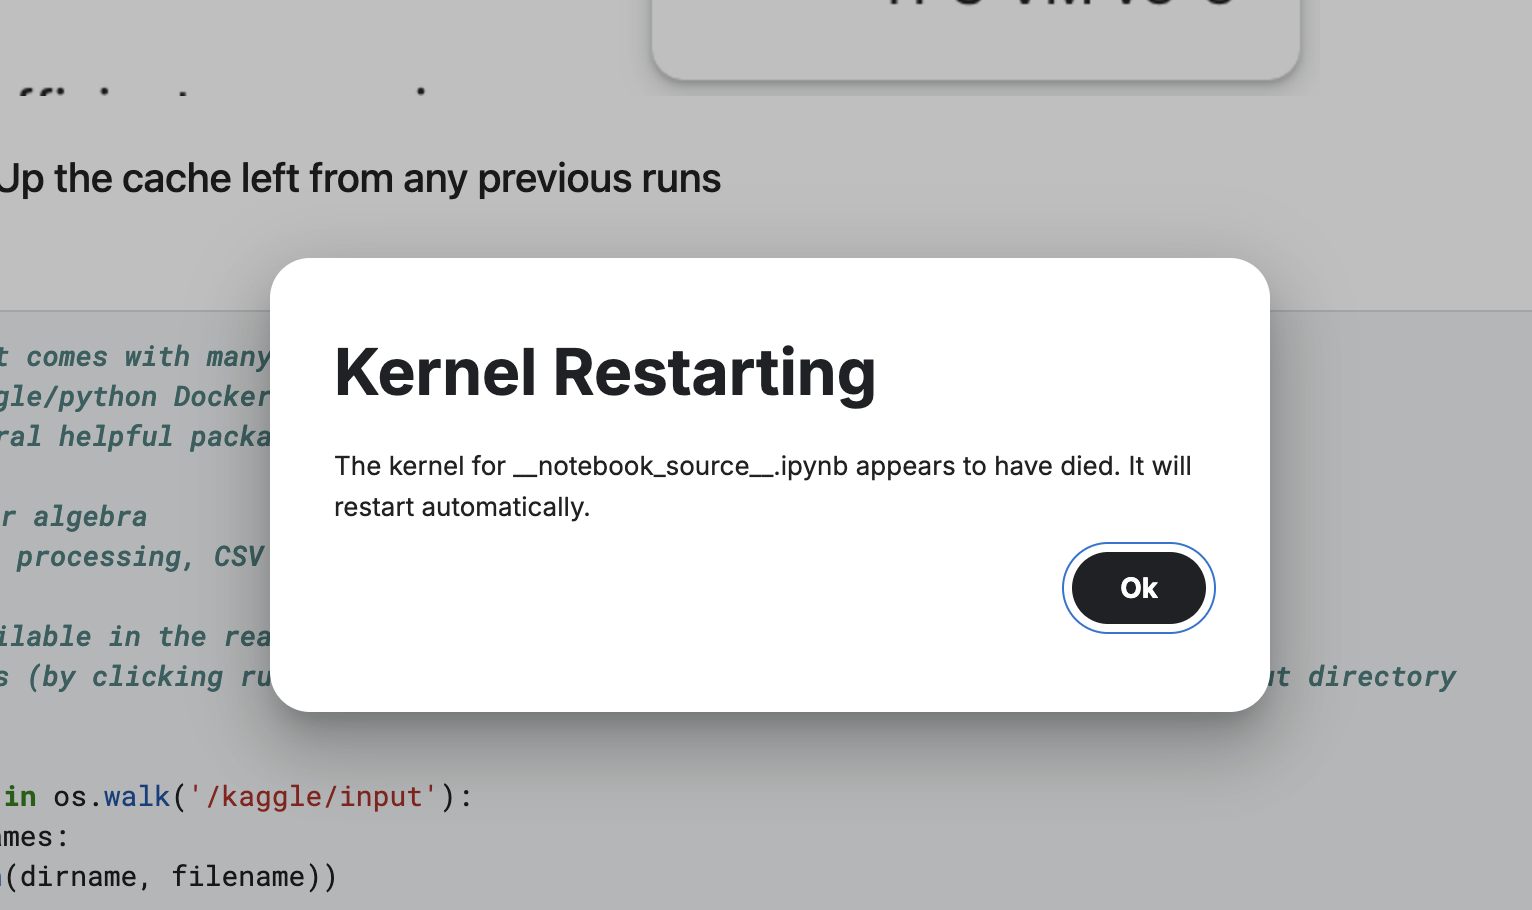
### 3. click OK and proceed

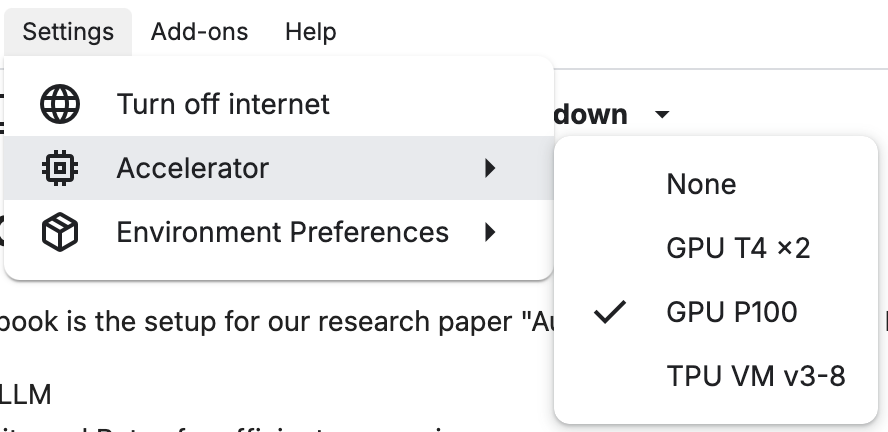

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


import gc
gc.collect()


%reset -f


!kill -9 $(nvidia-smi | awk '$5=="python" {print $3}')


import os
os._exit(0)  # Forces an immediate notebook restart


## Run again from here once the kernel has restarted

In [ ]:
!pip install --upgrade huggingface_hub

In [ ]:
!pip install -q transformers accelerate -U bitsandbytes

In [ ]:
!pip install -q sentencepiece

In [ ]:
!pip install git+https://github.com/pytorch/captum.git

## Please ensure you have setup a huggingface token before proceeding further. The steps to set it up are shown below:
### 1. Sign in to Hugging Face and goto profile
1. 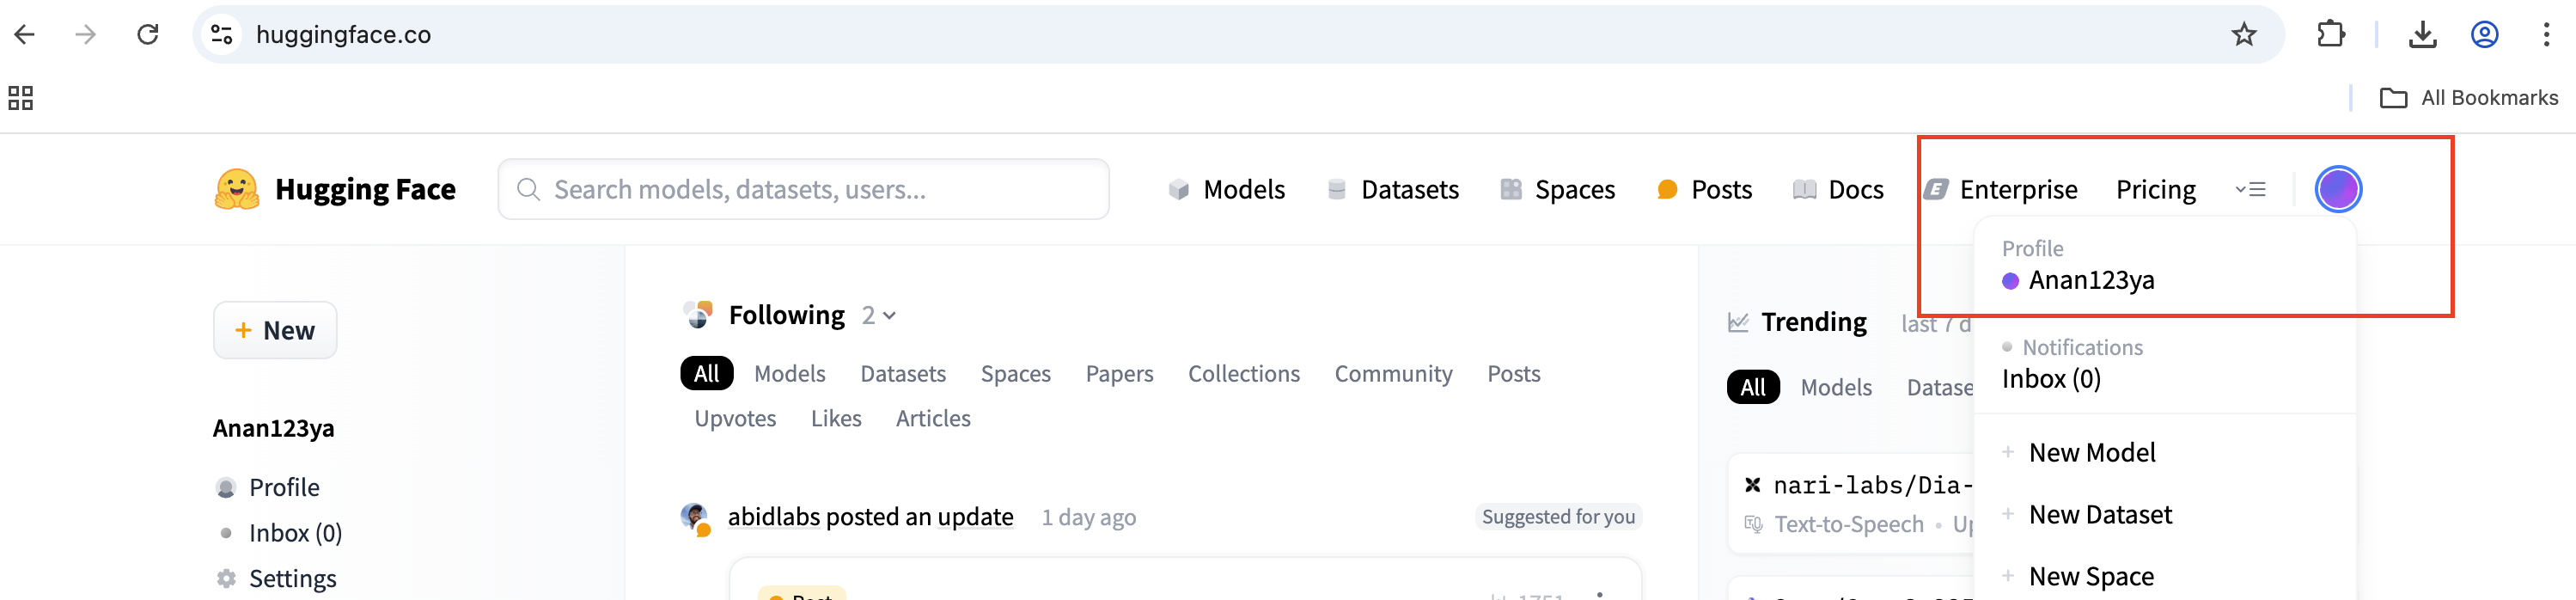
### 2. Next goto settings
2. 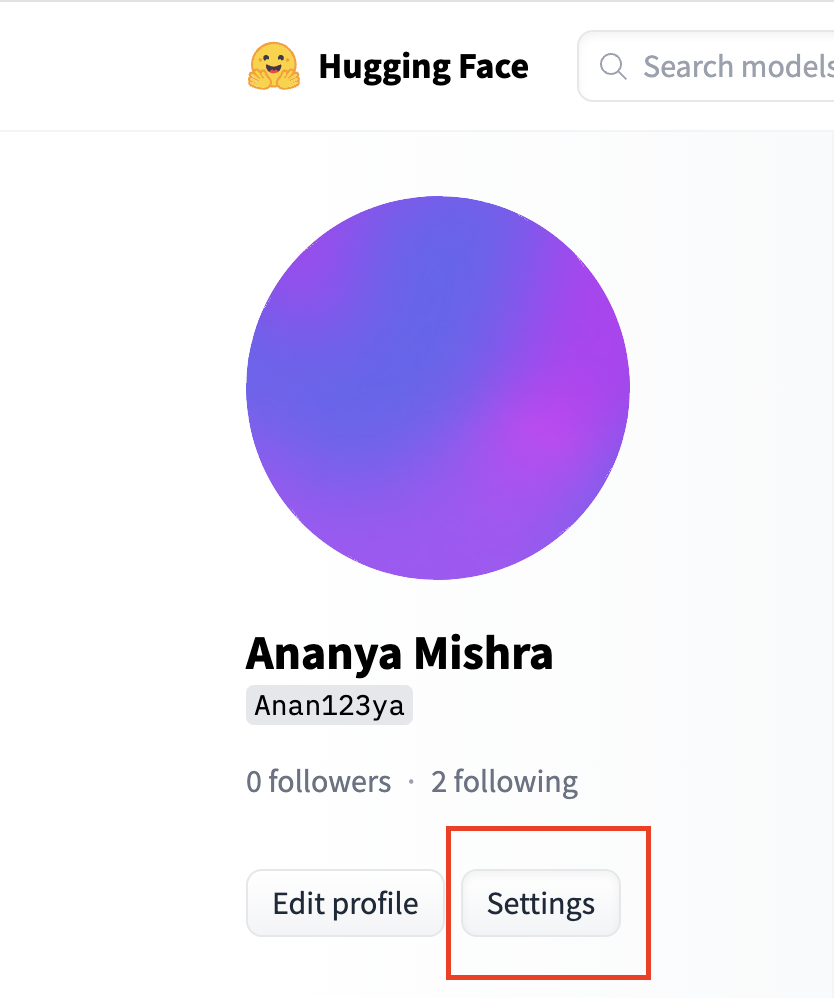
### 3. Now create a new token as shown
3. 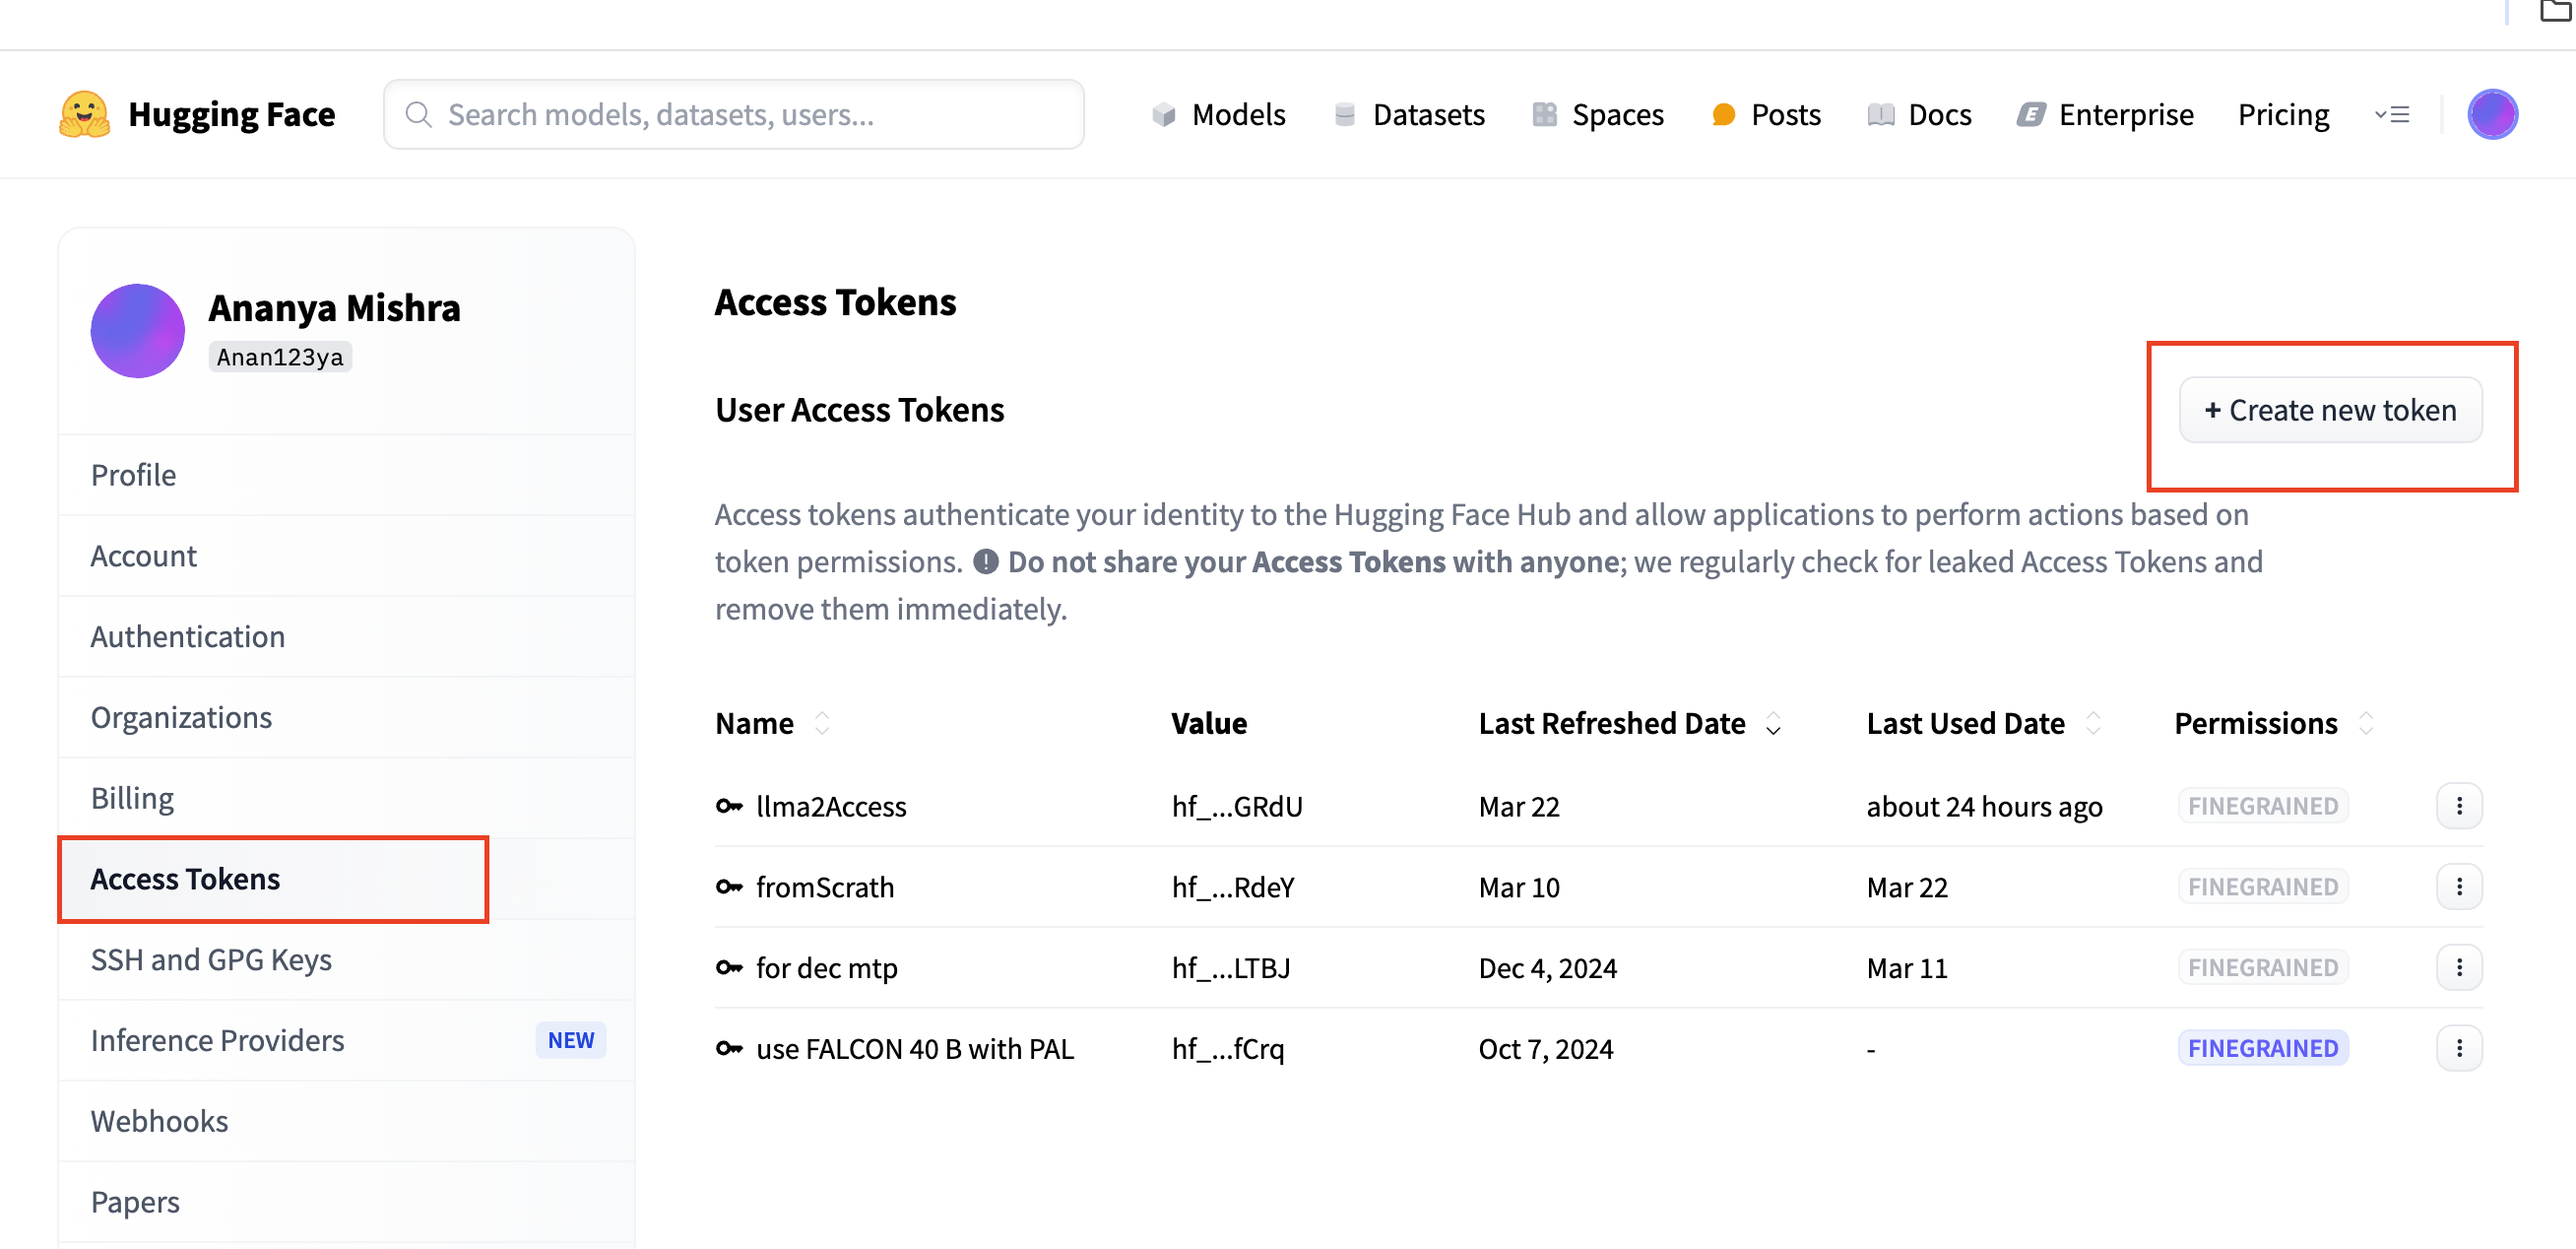
### 4. Add the token to secrets section in this notebook as shown below
4. 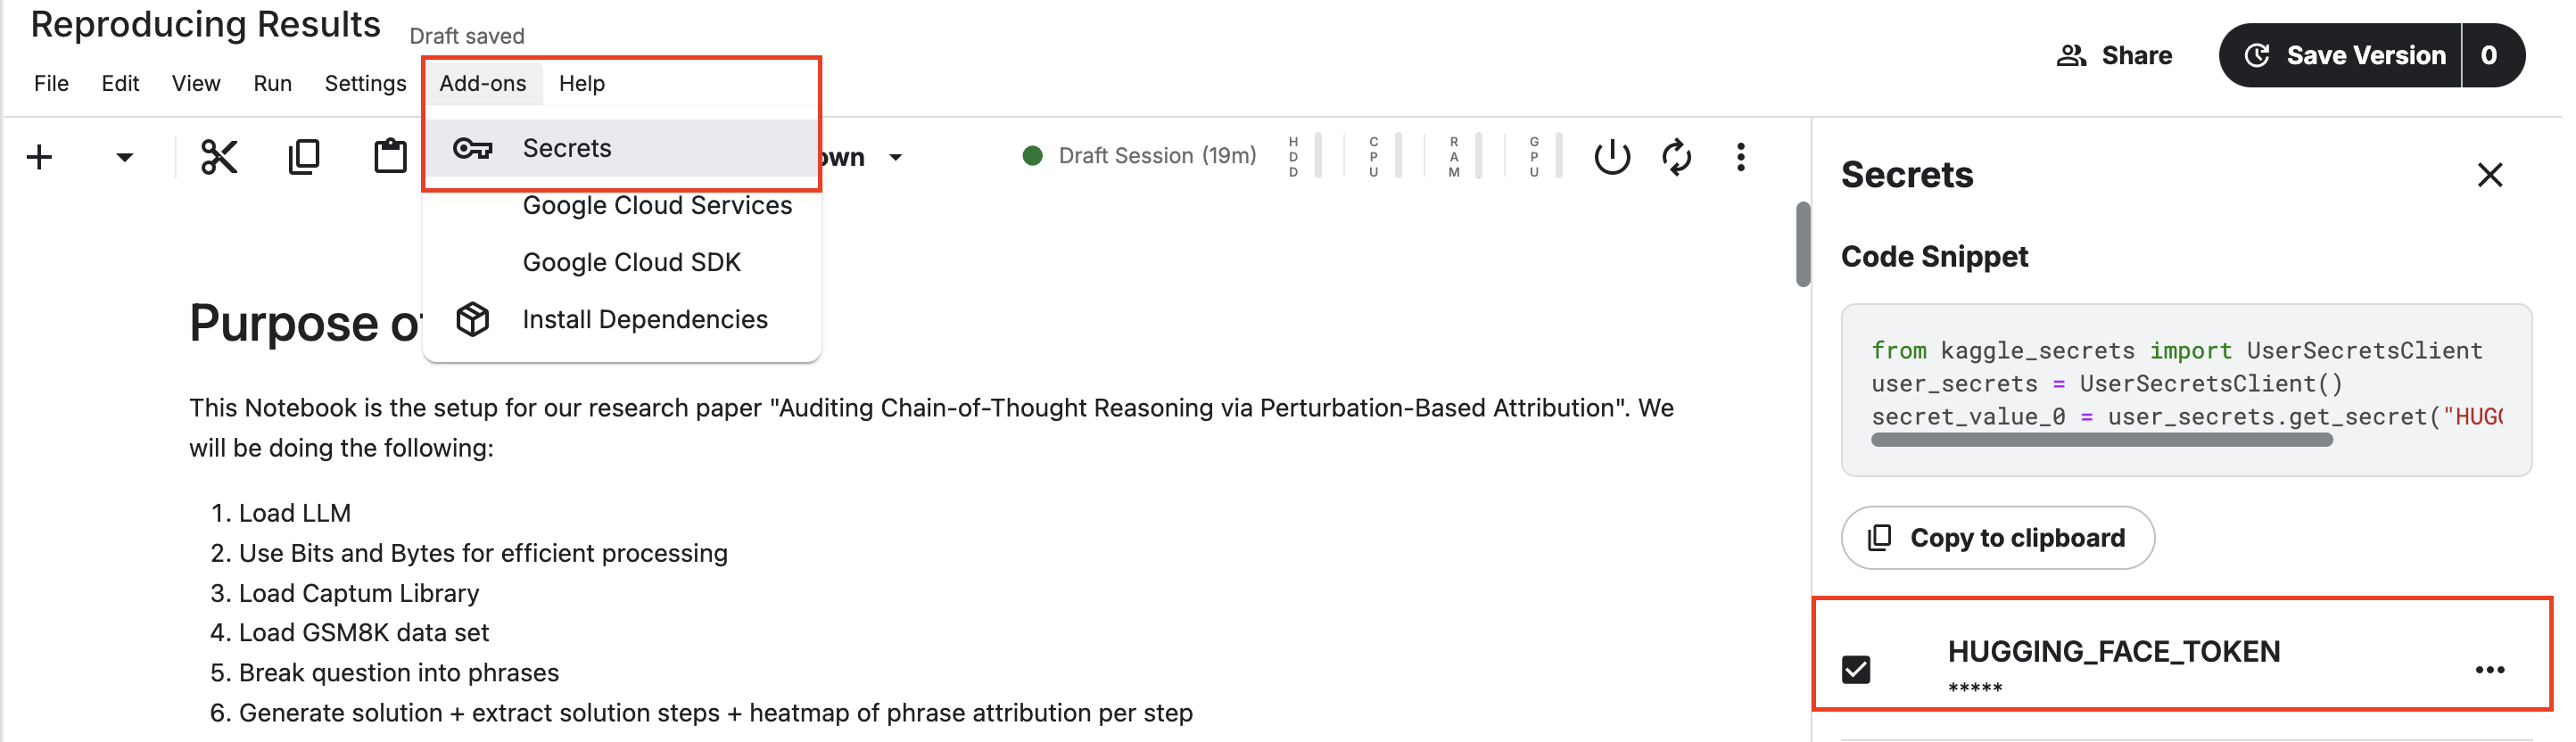
### We need it for access to the Deepseek Math Model and GSM8K dataset
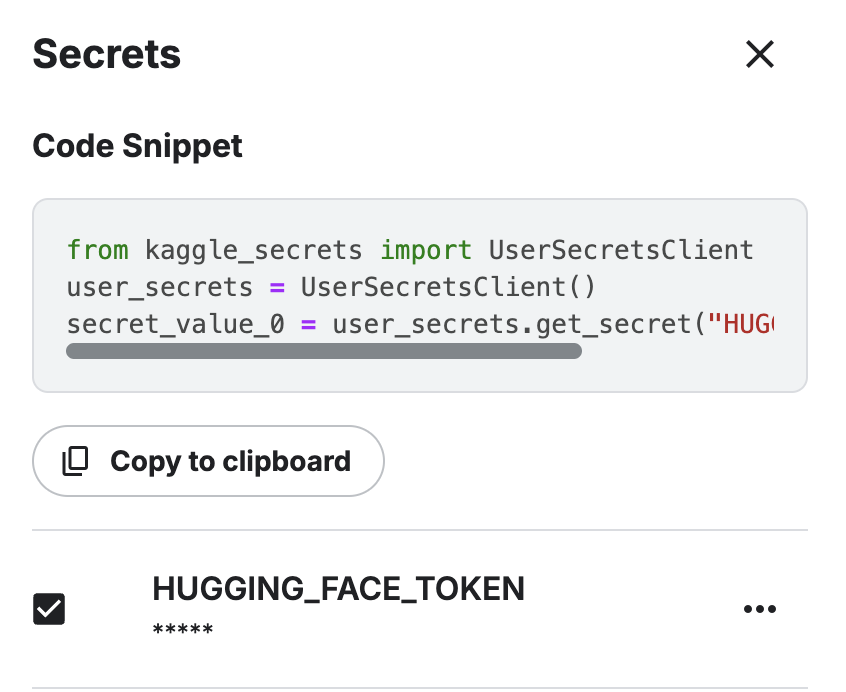
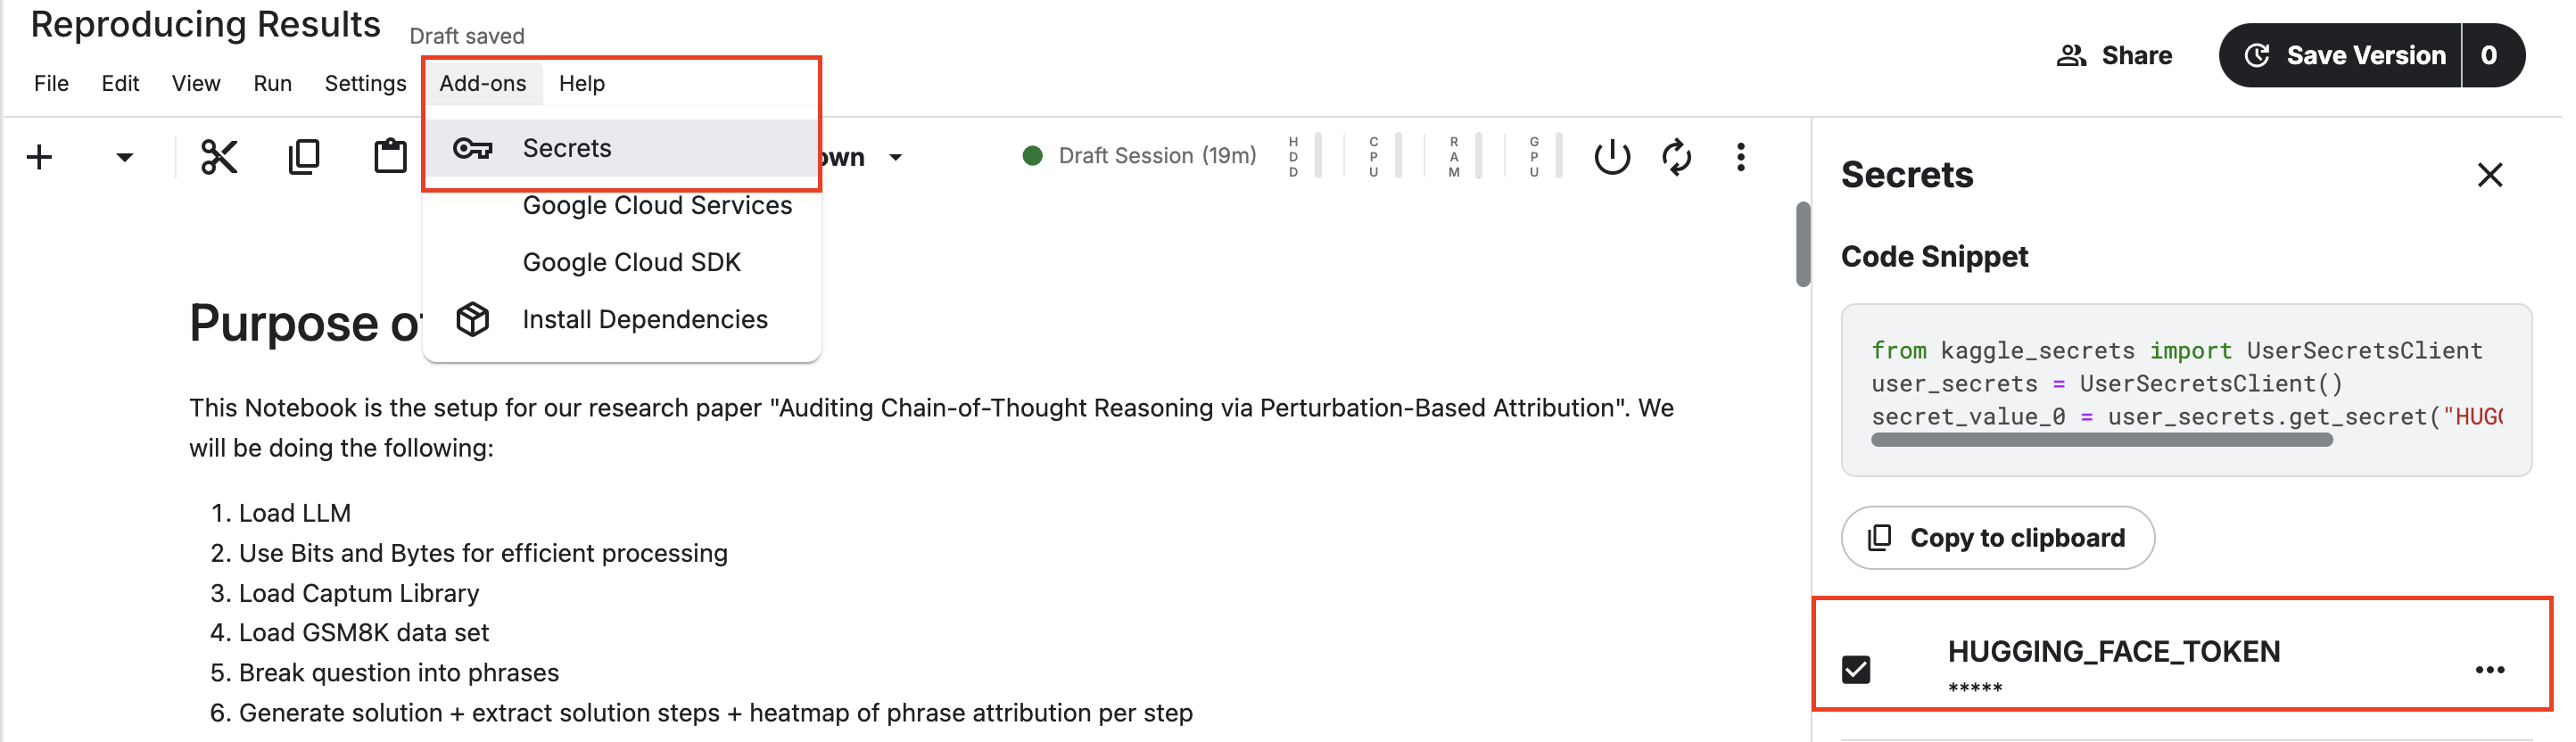

In [ ]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HUGGING_FACE_TOKEN")
login(secret_value_0)

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from captum.attr import (
    FeatureAblation, 
    ShapleyValues,
    LayerIntegratedGradients, 
    LLMAttribution, 
    LLMGradientAttribution, 
    TextTokenInput, 
    TextTemplateInput,
    ProductBaselines,
)

In [ ]:
def load_model(model_name, bnb_config):
    n_gpus = torch.cuda.device_count()
    max_memory = "10000MB"

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",  # dispatch efficiently the model on the available ressources
        max_memory = {i: max_memory for i in range(n_gpus)},
        trust_remote_code=True
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=True)

    # Needed for LLaMA tokenizer
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

def create_bnb_config():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    return bnb_config

## Model Selection
1. This cell will be used to set model which is loaded via huggingface
2. Please change model_name as per choice

In [ ]:
model_name = "deepseek-ai/deepseek-math-7b-instruct"

bnb_config = create_bnb_config()

model, tokenizer = load_model(model_name, bnb_config)
print(model.hf_device_map)  # shows where each layer is loaded

In [ ]:
from datasets import load_dataset

ds = load_dataset("openai/gsm8k", "main")

# Generate solution and split into steps

## Solution Generation
The generate_response() function will receive a question as input and generate solution with COT prompting

In [ ]:
# Ensure pad_token_id is set properly
tokenizer.pad_token = tokenizer.eos_token
def generate_response(prompt, extra_instruction="Solve the problem step by step:"):
    """Generates a response from the model given a modified math problem prompt."""
    modified_prompt = f"{extra_instruction}\n\n{prompt}"  
    inputs = tokenizer(modified_prompt, return_tensors="pt").to("cuda")
    
    with torch.no_grad():
        output = model.generate(**inputs, max_length=30000)

    return tokenizer.decode(output[0], skip_special_tokens=True)

## Breaking question into phrases
1. This cell has functions that split a question into phrases
2. Those phrases are then used to create a template in a format compatible with captum
3. You can read more about captum's TextTemplateInput at https://captum.ai/tutorials/Llama2_LLM_Attribution

In [ ]:
#breaking into phrases
import re
from dataclasses import dataclass
from typing import List
i=47
@dataclass
class CustomTextTemplateInput:
    template: str
    values: List[str]

def break_into_phrases(paragraph: str, max_words: int = 5) -> List[str]:
    """Split paragraph into meaningful phrases with max_words limit"""
    # First split on all possible phrase boundaries
    splits = re.split(r'([,;.!?]|\s+(?:but|then|and|or|so)\s+)', paragraph)
    
    phrases = []
    current_phrase = []
    
    for item in splits:
        item = item.strip()
        if not item:
            continue
        
        # Skip punctuation/conjunctions
        if re.fullmatch(r'^[,;.!?]|\s*(?:but|then|and|or|so)\s*$', item):
            if current_phrase:  # Finalize current phrase before separator
                phrases.append(' '.join(current_phrase))
                current_phrase = []
            continue
        
        words = item.split()
        for word in words:
            current_phrase.append(word)
            if len(current_phrase) >= max_words:
                phrases.append(' '.join(current_phrase))
                current_phrase = []
    
    if current_phrase:  # Add any remaining words
        phrases.append(' '.join(current_phrase))
    
    return phrases

def create_input_custom(paragraph: str) -> CustomTextTemplateInput:
    """Create template with placeholders while preserving original structure"""
    phrases = break_into_phrases(paragraph)
    
    # Create the template by replacing each phrase with {}
    template = paragraph
    for phrase in phrases:
        template = template.replace(phrase, "{}", 1)
    
    return TextTemplateInput(template=template, values=phrases)


In [ ]:
#collecting steps from model output
from typing import List

def extract_reasoning_steps(model_response: str, max_steps: int = 15, verbose: bool = False) -> List[str]:
    """
    Extracts unique reasoning steps from a model response string.
    
    Args:
        model_response: Raw response text from the model
        max_steps: Maximum number of steps to return (default: 15)
        verbose: Whether to print formatted steps (default: False)
    
    Returns:
        List of unique reasoning steps, ordered by appearance
    """
    # Process response into unique steps
    steps = [line.strip() for line in model_response.split('\n') if line.strip()]
    unique_steps = []
    
    for step in steps:
        if step not in unique_steps:
            unique_steps.append(step)
    
    # Trim to requested maximum steps
    final_steps = unique_steps[:max_steps]
    
    # Optional verbose output
    if verbose:
        print("\nExtracted Reasoning Steps:")
        for idx, step in enumerate(final_steps):
            print(f"Step {idx}: {step}")
    
    return final_steps

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List
from typing import Any

def generate_step_attribution_heatmaps(
    input_custom: TextTemplateInput,  # Output from create_input_custom
    unique_steps: List[str],          # Array of generated steps
    model: Any,                       # Your LLM model
    tokenizer: Any,                   # Your tokenizer
    max_steps: int = None             # Optional limit for number of steps
)-> tuple[np.ndarray, dict]:  # ← Explicit return type:
    """
    Generates vertical heatmaps showing phrase attribution scores for all reasoning steps.
    
    Parameters:
    input_custom (TextTemplateInput): Processed input structure with phrases
    unique_steps (List[str]): Array of generated reasoning steps
    model: Your loaded language model
    tokenizer: Your loaded tokenizer
    max_steps (int): Maximum number of steps to visualize
    """
    # Initialize attribution objects
    fa = FeatureAblation(model)
    llm_attr = LLMAttribution(fa, tokenizer)

    # Limit steps if requested
    if max_steps is not None:
        unique_steps = unique_steps[2:max_steps]
    
    # Initialize storage
    attribution_matrix = np.zeros((len(input_custom.values), len(unique_steps)))
    phrases = input_custom.values

    # New: Track phrases with lowest attributions per step
    low_attrib_phrases = {}
    num_phrases = len(phrases)
    cutoff = num_phrases // 2  # Take bottom 50%
    
    # Process each step
    for step_idx, target_step in enumerate(unique_steps):
        # Compute attributions
        attr_res = llm_attr.attribute(input_custom, target=target_step)
        
        # Get phrase-level scores
        total_attr = attr_res.token_attr.sum(dim=0).cpu().numpy()
        phrases = input_custom.values
        
        # Store attributions
        attribution_matrix[:, step_idx] = total_attr
        
        
        # Create visualization
        if step_idx < 1:  
            plt.figure(figsize=(8, len(phrases) * 0.5))
            sns.heatmap(
                np.array(total_attr).reshape(-1, 1),
                annot=[[f"{v:.2f}"] for v in total_attr],
                fmt="",
                yticklabels=phrases,
                xticklabels=["Attribution"],
                cmap="Blues",
                linewidths=0.5,
                linecolor="gray",
                cbar=True
            )
        
            # Truncate long step text for title
            truncated_step = (target_step[:75] + '...') if len(target_step) > 75 else target_step
            plt.title(f"Phrase Attribution\nStep {step_idx+1}: {truncated_step}", pad=20)
            plt.ylabel("Input Phrases")
            plt.xlabel("Attribution Score")
            plt.tight_layout()
            filename = f"step_{step_idx+1}_attribution.png"
            plt.savefig(filename, dpi=300)
            plt.show()

    # Print raw matrix
    print("\nRaw Attribution Matrix:")
    print(attribution_matrix)
    
    for step_idx in range(attribution_matrix.shape[1]):
        # Get indices sorted by ascending attribution scores
        sorted_indices = np.argsort(attribution_matrix[:, step_idx])
        
        # Store phrase indices with lowest 50% scores
        low_attrib_phrases[step_idx] = sorted_indices[:cutoff].tolist()

    print("\nPhrases with lowest 50% scores per step:")
    for step_idx, phrase_indices in low_attrib_phrases.items():
        print(f"Step {step_idx+1}: Phrases {phrase_indices}")
    return attribution_matrix, low_attrib_phrases

## Pre processing
Sometimes the model generated output has latex symbols that are unsupported so cleaning them up is required

In [ ]:
import re

def clean_latex(text: str) -> str:
    """
    Clean up LaTeX symbols such as \boxed, \frac, etc., by removing them or converting them into plain text.
    
    Args:
        text: The string containing LaTeX symbols.
        
    Returns:
        A cleaned version of the string without LaTeX formatting.
    """
    # Remove common LaTeX symbols
    text = re.sub(r'\\boxed{(.*?)}', r'\1', text)  # Remove \boxed{...}
    text = re.sub(r'\\frac{(.*?)}{(.*?)}', r'(\1/\2)', text)  # Convert \frac{a}{b} to (a/b)
    text = re.sub(r'\\[a-zA-Z]+\{.*?\}', '', text)  # Remove other LaTeX commands like \text{...}, \frac{...}
    
    # Optionally remove any LaTeX math mode content
    text = re.sub(r'\$.*?\$', '', text)  # Remove content between $...$ (inline math)
    text = re.sub(r'\\[a-zA-Z]+', '', text)  # Remove other LaTeX commands
    
    return text.strip()
def process_single_question(question_idx: int, max_steps: int = 15) -> tuple:
    """
    Processes a single question from GSM8K dataset and returns analysis components.
    
    Args:
        question_idx: Index of the question in the dataset
        max_steps: Maximum number of reasoning steps to analyze
        
    Returns:
        tuple: (phrases, unique_steps, attribution_matrix, low_attrib_phrases)
            - phrases: List[str] of extracted phrases
            - unique_steps: List[str] of model's reasoning steps
            - attribution_matrix: np.ndarray of phrase attributions per step
            - low_attrib_phrases: Dict[int, List[int]] of low-attribution phrase indices per step
    """
    # Get question and generate response
    question = ds['test'][question_idx]["question"]
    model_response = clean_latex(generate_response(question))
    
    # Process input into phrases
    input_custom = create_input_custom(question)
    phrases = input_custom.values
    
    # Extract reasoning steps
    unique_steps = extract_reasoning_steps(model_response, max_steps=max_steps)
    
    # Calculate attributions
    attribution_matrix, low_attrib_phrases = generate_step_attribution_heatmaps(
        input_custom=input_custom,
        unique_steps=unique_steps,
        model=model,
        tokenizer=tokenizer,
        max_steps=max_steps
    )
    
    return phrases, unique_steps, attribution_matrix, low_attrib_phrases

## Single question Attribution 
This step shows you all the relevant outputs for a single question as a sample

In [ ]:
from captum.attr import TextTemplateInput
# Process question index 47
phrases, steps, att_matrix, low_attrib = process_single_question(48)

# Print results
print("Phrases:", phrases)
print("Steps:", steps)
print("Attribution Matrix Shape:", att_matrix.shape)
print("Low-attribution phrases for Step 1:", low_attrib)

In [ ]:
def process_multiple_questions(question_indices: List[int], max_steps: int = 15) -> dict:
    """
    Processes multiple questions from the GSM8K dataset.
    
    Args:
        question_indices: List of question indices to process
        max_steps: Max number of reasoning steps to analyze for each
    
    Returns:
        A dictionary mapping question index to its results:
            {
                idx1: {
                    "phrases": ...,
                    "steps": ...,
                    "att_matrix": ...,
                    "low_attrib": ...
                },
                ...
            }
    """
    results = {}
    
    for idx in question_indices:
        print(f"\nProcessing question index: {idx}")
        try:
            phrases, steps, att_matrix, low_attrib = process_single_question(idx, max_steps=max_steps)
            results[idx] = {
                "phrases": phrases,
                "steps": steps,
                "att_matrix": att_matrix,
                "low_attrib": low_attrib
            }
        except Exception as e:
            print(f"Error processing question {idx}: {e}")
            continue
    
    return results


## Batch Processing Multiple Questions
1. If the output generation takes time it is completely expected
2. It will trigger the model to solve the range of entered problems step by step, extract the steps and phrases and generate atrribution matrices
3. A question can be long with multiple phrases and solution steps
4. try to verify the step works fine by giving a smaller range

In [ ]:
all_results = process_multiple_questions(list(range(46, 51)), max_steps=20) #provided range is as per test split of GSM8K dataset

## Saving the intermediate results
1. This step will trigger save the intermediate results in the form of a csv
2. You can find the saved file by following the instructions below:
3. Click the leftward arrow at the bottom right to open the side bar
4. 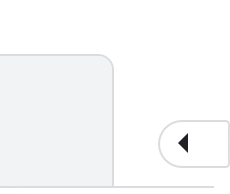
5. Hit the refresh to load the latest updates
6. 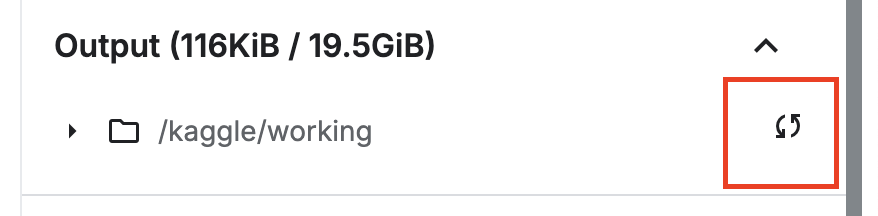
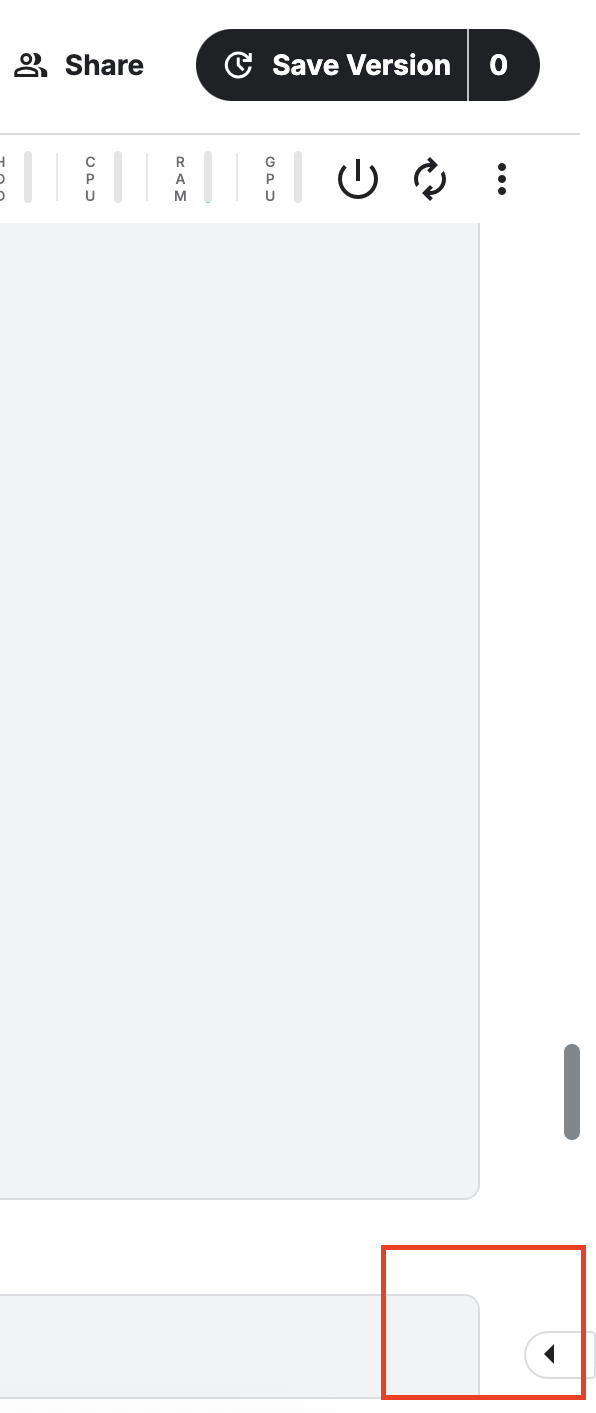

In [ ]:
import pandas as pd

def save_results_to_csv(all_results: dict, output_csv_path: str):
    # Prepare data to save in the CSV file
    data = []
    
    for quid, result in all_results.items():
        question = ds['test'][quid]["question"]   # Assuming 'question' 
        all_steps = result.get('steps', [])[2:]  # Concatenate all steps into a single string
        all_phrases = result.get('phrases', [])  # Concatenate all phrases into a single string
        
        # Append the data
        data.append({
            'quid': quid,
            'question': question,
            'all_steps': all_steps,
            'all_phrases': all_phrases
        })
    
    # Create a DataFrame
    df = pd.DataFrame(data)
    
    # Save to CSV
    df.to_csv(output_csv_path, index=False)
    print(f"Results saved to {output_csv_path}")

# the results from `process_multiple_questions` are stored in `all_results`
output_csv_path = '/kaggle/working/pre_ground_truth_46to50.csv'#change the file name here for a different range of questions
save_results_to_csv(all_results, output_csv_path) 


In [ ]:
import pandas as pd

def evaluate_low_attrib_overlap(ground_truth_csv_path, all_results):
    ground_truth = pd.read_csv(ground_truth_csv_path)

    # Prepare mapping: question_id -> list of (step, matched_phrases)
    question_to_steps = {}
    for idx, row in ground_truth.iterrows():
        qid = int(row['Question'])
        step_text = row['Step']
        
        # Fix quotes
        matched_phrases_raw = row['Matched Phrases']
        if isinstance(matched_phrases_raw, str):
            matched_phrases_fixed = matched_phrases_raw.replace('“', '"').replace('”', '"')
            try:
                matched_phrases = eval(matched_phrases_fixed)
            except:
                matched_phrases = []
        else:
            matched_phrases = []

        if qid not in question_to_steps:
            question_to_steps[qid] = []
        
        question_to_steps[qid].append({
            'step': step_text,
            'matched_phrases': matched_phrases
        })

    # Now, for each question, check overlaps
    ignored_steps_per_question = []

    for qid in sorted(question_to_steps.keys()):
        q_steps = question_to_steps[qid]
        ignored_steps_count = 0
        
        if qid not in all_results:
            print(f"Warning: Question ID {qid} not found in all_results")
            ignored_steps_per_question.append(None)
            continue
        
        result_entry = all_results[qid]
        
        if 'low_attrib' not in result_entry:
            print(f"Warning: low_attrib missing for question {qid}")
            ignored_steps_per_question.append(None)
            continue
        
        phrases_list = result_entry['phrases']
        low_attrib_per_step = result_entry['low_attrib']  # 🔥 should be list of lists

        print(f"\n=== Question {qid} ===")
        
        for step_idx, step_entry in enumerate(q_steps):
            matched_phrases = step_entry['matched_phrases']
            
            if step_idx >= len(low_attrib_per_step):
                print(f"Warning: Step {step_idx} not found in low_attrib for question {qid}")
                continue

            # 🔥 low attribution phrases for THIS STEP
            low_attrib_indices = low_attrib_per_step[step_idx]
            step_low_attrib_phrases = [phrases_list[i] for i in low_attrib_indices]

            print(f"Step {step_idx+1}: Low Attribution Phrases ({len(step_low_attrib_phrases)}): {step_low_attrib_phrases}")

            if matched_phrases is None:
                continue
            overlap_phrases = [phrase for phrase in matched_phrases if phrase in step_low_attrib_phrases]
            # Calculate ignored value based on the number of matched phrases found in low attribution
            if matched_phrases:
                ignored = len(overlap_phrases) / len(matched_phrases)
                print(f"[+] Question {qid} Step {step_idx + 1}: has matched phrases overlapped: {overlap_phrases}")
            else:
                ignored = 0  # If there are no matched phrases, no overlap, hence no ignored

            print(f"[+] Step {step_idx + 1}: Ignored Ratio = {ignored:.2f}")

            if ignored > 0.5:
                ignored_steps_count += 1
                print(f"[+] Question {qid} Step {step_idx + 1}: Ignored because ignored ratio is > 0.5")
            else:
                print(f"[+] Question {qid} Step {step_idx + 1}: NOT Ignored because ignored ratio is <= 0.5")
       
        ignored_steps_per_question.append(ignored_steps_count)

    return ignored_steps_per_question


## Ground Truth Needs to be Supplied Externally
### 1. Download the pre_ground_truth_46to50.csv file
### 2. Use it to create the human annotated ground truth from it by matching every step with top three relevant phrases
### 3. The column headings for it are: Step, Matched Phrases, Question (please refer sample files in the exp_data to understand better)
### 4. Then upload the file named as per the following naming convention: ground_truth_46to50.csv as a dataset as follows:
 5. 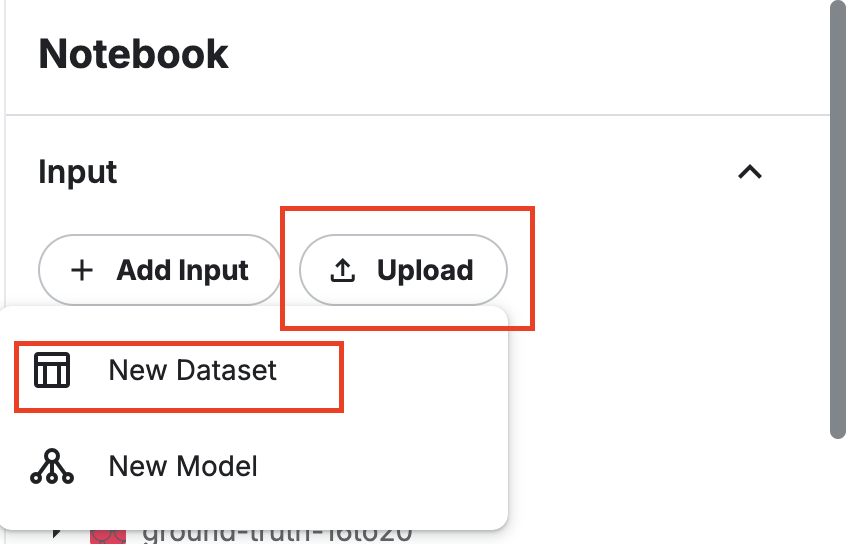
### 5. Drag and drop the ground truth file and name the dataset same as the file for simplicity
6. 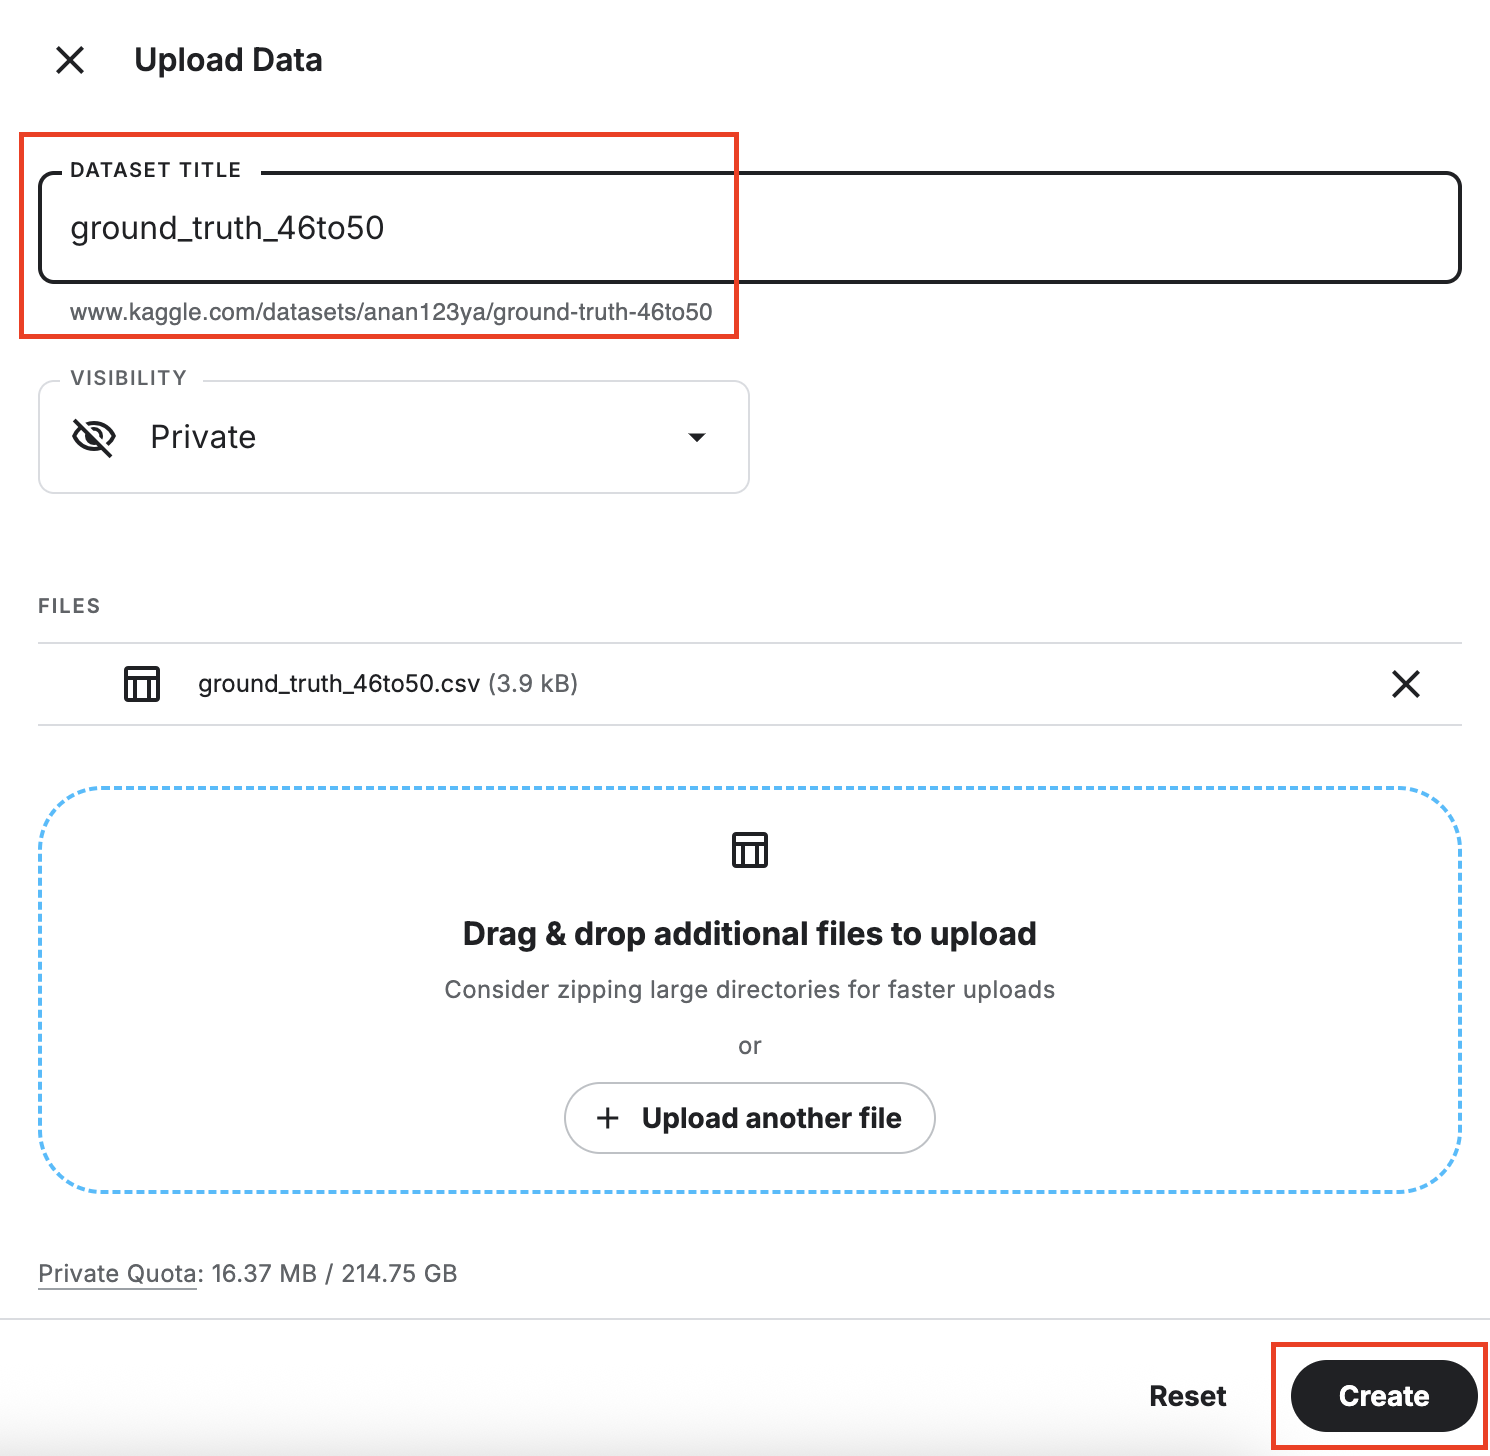
### 6. Interpretting Results
The reultant vector has number of steps per question marked as unfaithful
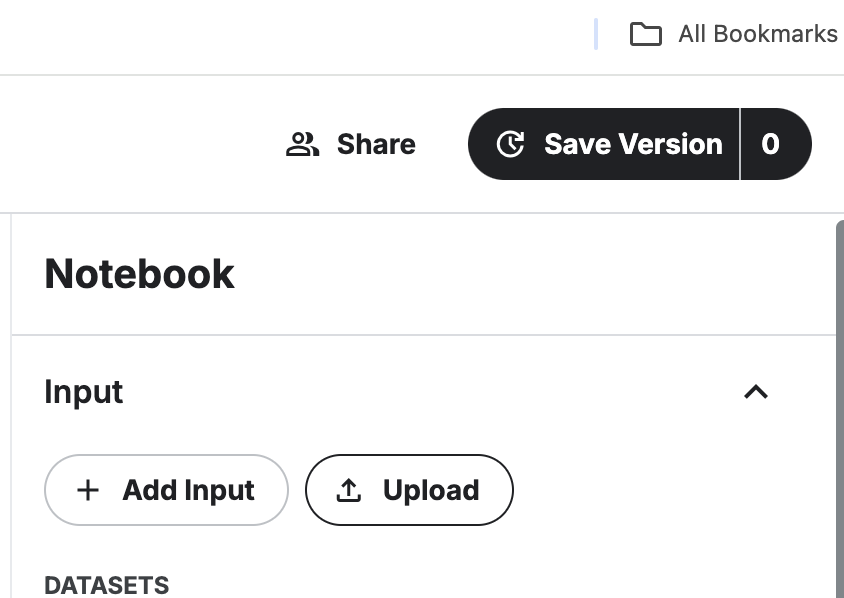
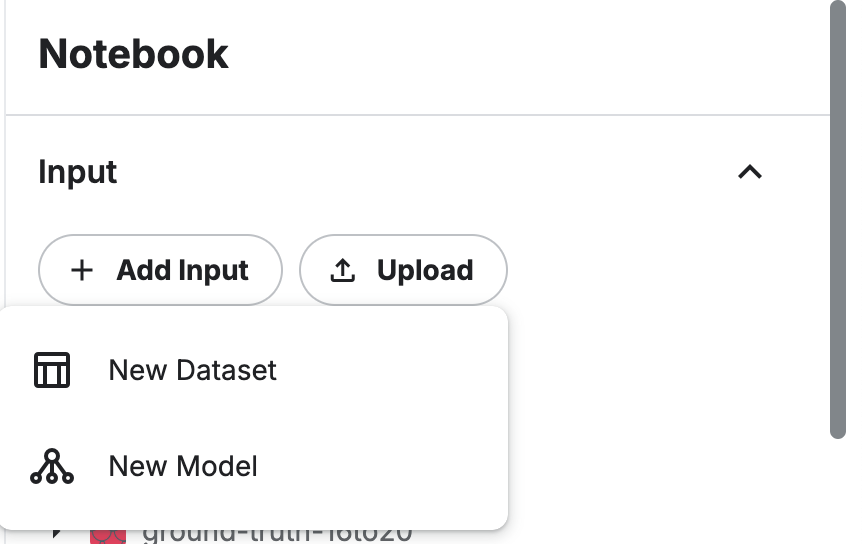
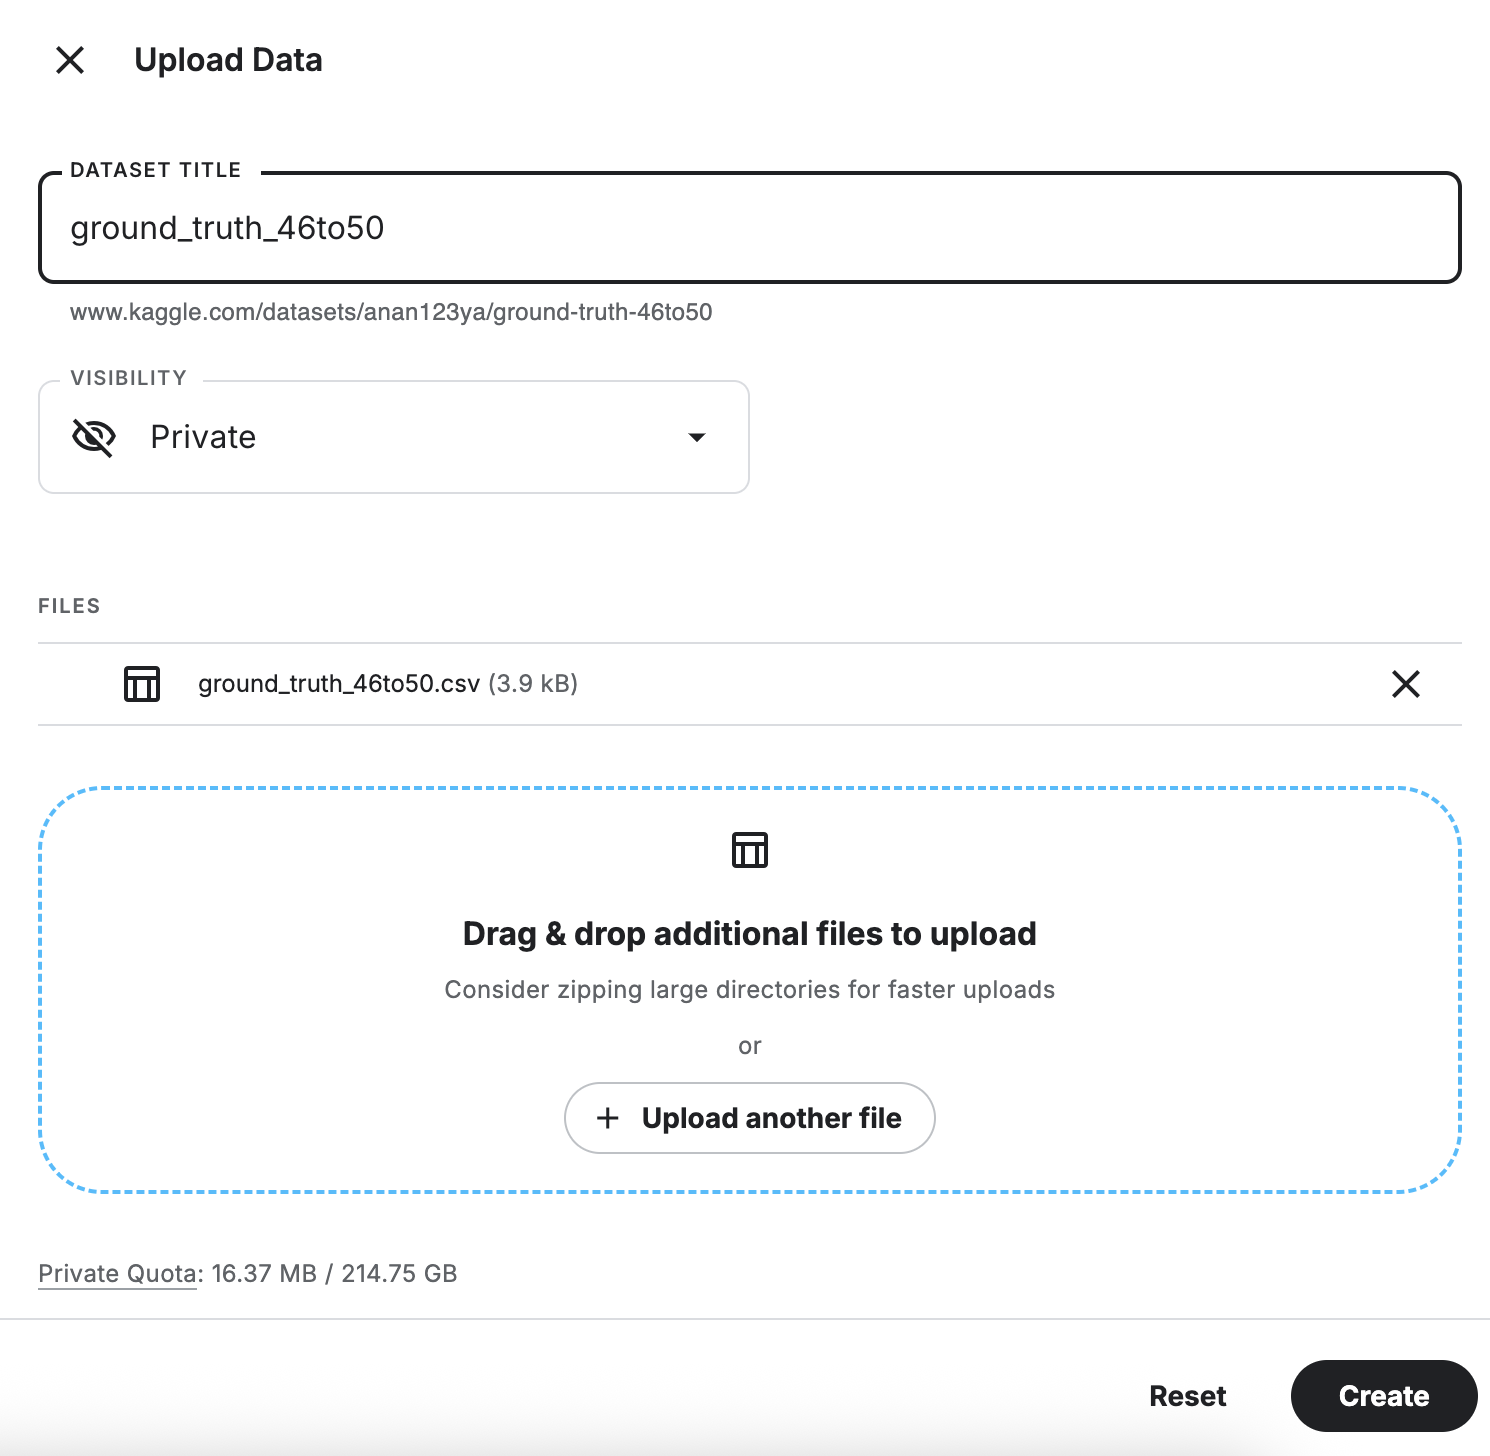

In [ ]:
result = evaluate_low_attrib_overlap('/kaggle/input/ground-truth-46to50/ground_truth_46to50.csv', all_results)
print(result)

## Visualization of Results
1. Results_of_ignored_steps.csv is populated manually after each 5 question run
2. Sample file for the same is present in the exp_data folder
3. The results are to be uploaded as another dataset called "results-for-graph" with filename "results_of_ignored_steps.csv"

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load your CSV ---
# Replace with your actual filename
df = pd.read_csv('/kaggle/input/results-for-graph/results_of_ignored_steps.csv')
# Sort by ratio (optional for visual clarity)
df = df.sort_values(by="Ratio of ignored/total steps", ascending=False)

# Plot 1: Number of Ignored Steps per Question
plt.figure(figsize=(14, 6))
plt.bar(df["Question_ID"], df["number_of_steps_that_ignored_relevant_phrases"], color='salmon')
plt.xlabel("Question ID")
plt.ylabel("Number of Steps Ignoring Relevant Phrases")
plt.title("Ignored Reasoning Steps per Question")
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.savefig("ignored_steps_count.png", dpi=300)
plt.show()

# Plot 2: Ratio of Ignored Steps per Question
plt.figure(figsize=(14, 6))
plt.bar(df["Question_ID"], df["Ratio of ignored/total steps"], color='seagreen')
plt.xlabel("Question ID")
plt.ylabel("Ignored Steps Ratio")
plt.title("Ratio of Ignored to Total Reasoning Steps per Question")
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.savefig("ignored_steps_ratio.png", dpi=300)
plt.show()
plt.savefig("bar_chart_steps.png", dpi=300, bbox_inches='tight')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("/kaggle/input/results-for-graph/results_of_ignored_steps.csv")

# Extract the relevant column
ignored_counts = df["number_of_steps_that_ignored_relevant_phrases"]

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(ignored_counts, bins=range(0, ignored_counts.max()+2), edgecolor='black', color='skyblue', align='left')
plt.xlabel("Number of Ignored Steps")
plt.ylabel("Number of Questions")
plt.title("Distribution of Ignored Reasoning Steps Across Questions")
plt.xticks(range(0, ignored_counts.max()+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save and show
plt.savefig("histogram_ignored_steps_distribution.png", dpi=300)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV
df = pd.read_csv("/kaggle/input/results-for-graph/results_of_ignored_steps.csv")

# Total counts
total_steps = df["Total_number_of_steps"].sum()
unfaithful_steps = df["number_of_steps_that_ignored_relevant_phrases"].sum()
faithful_steps = total_steps - unfaithful_steps

# Labels and sizes
labels = ['Faithful Steps', 'Unfaithful Steps']
sizes = [faithful_steps, unfaithful_steps]
colors = ['#4CAF50', '#F44336']  # green, red

# --- Pie Chart ---
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title("Faithful vs Unfaithful Reasoning Steps")
plt.axis('equal')  # Equal aspect ratio for a circle
plt.tight_layout()
plt.savefig("faithful_vs_unfaithful_pie.png", dpi=300)
plt.show()

# --- Donut Chart ---
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes, labels=labels, colors=colors, autopct='%1.1f%%',
    startangle=90, counterclock=False, wedgeprops=dict(width=0.4)
)
plt.title("Faithful vs Unfaithful Reasoning Steps (Donut)")
plt.axis('equal')
plt.tight_layout()
plt.savefig("faithful_vs_unfaithful_donut.png", dpi=300)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv("/kaggle/input/results-for-graph/results_of_ignored_steps.csv")

# Get the ignored step counts
ignored_steps = df["number_of_steps_that_ignored_relevant_phrases"]

# Sort the data for CDF
sorted_counts = np.sort(ignored_steps)
cdf = np.arange(1, len(sorted_counts)+1) / len(sorted_counts)

# Plot CDF
plt.figure(figsize=(8, 6))
plt.plot(sorted_counts, cdf, marker='o', linestyle='-', color='royalblue')
plt.xlabel("Number of Ignored Steps")
plt.ylabel("Cumulative Fraction of Questions")
plt.title("CDF of Ignored Reasoning Steps per Question")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save and show

plt.show()


## You can stop running from here
1. Only needed for labeling model answers
2. This cell we measure the performance of model by comparing final results in order to catagorize whether model answers a question correctly or not
3. It will take time to process as we trigger model to generate all answers at once for labelling as correct or incorrect

In [ ]:
def extract_final_answer(text):
    """
    Extracts the final numeric answer from the last line of the text.
    """
    import re
    match = re.search(r"[-+]?\d*\.?\d+", text.strip().split("\n")[-1])
    return match.group() if match else None

def compute_correctness_array(ds, model_outputs, question_range):
    """
    For each question in the range, compare the model's final answer
    to the ground truth. Return a list of 1s (correct) and 0s (incorrect).
    """
    correctness_array = []

    for i in question_range:
        gt_raw = str(ds['test'][i]['answer']).strip()
        pred_raw = str(model_outputs[i]).strip()

        gt_answer = extract_final_answer(gt_raw)
        pred_answer = extract_final_answer(pred_raw)

        is_correct = int(gt_answer == pred_answer)
        correctness_array.append(is_correct)

        # Debug prints
        print(f"\nQuestion {i}:")
        print(f"  Ground Truth Answer: {gt_answer}")
        print(f"  Model Prediction:    {pred_answer}")
        print(f"  --> {'Correct ✅' if is_correct else 'Incorrect ❌'}")

    return correctness_array


In [ ]:
# Example: Generate model outputs for questions in range(0, 100)
model_outputs = []
for i in range(51):
    question = ds['test'][i]['question']
    output =generate_response(question) # Replace with actual model call
    model_outputs.append(output)

In [ ]:
# Assuming `ds` is your dataset and `model_outputs` is a list of CoT responses
question_range = range(0,51)
correctness_array = compute_correctness_array(ds, model_outputs, question_range)

print(correctness_array)  # e.g., [1, 1, 0, 1, 0, ...]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("/kaggle/input/results-right-wrong/results_of_ignored_steps_with_right_wrong.csv")

# Categorize ignorance severity
df['Ignorance_Severity'] = df['Ratio of ignored/total steps'].apply(
    lambda x: 'High' if x > 0.3 else 'Low'
)

# Aggregate counts
counts = df.groupby(['Correctness', 'Ignorance_Severity']).size().unstack()

# Plot
sns.set_style("whitegrid")
counts.plot(kind='bar', stacked=True, color=['#ffffff', '#000000'])
plt.xlabel('Correctness (0=Incorrect, 1=Correct)')
plt.ylabel('Number of Questions')
plt.title('Ignorance Severity in Correct vs. Incorrect Answers')
plt.legend(title='Ignorance Severity')
plt.xticks(rotation=0)
plt.show()

In [ ]:
import pandas as pd

# Load your data
df = pd.read_csv("/kaggle/input/results-right-wrong/results_of_ignored_steps_with_right_wrong.csv")

# Define thresholds
def categorize(row):
    if row['Correctness'] == 1:  # Correct answers
        if row['Ratio of ignored/total steps'] == 0:
            return 'Correct_0'
        elif row['Ratio of ignored/total steps'] <= 0.3:
            return 'Correct_low'
        else:
            return 'Correct_high'
    else:  # Incorrect answers
        if row['Ratio of ignored/total steps'] == 0:
            return 'Incorrect_0'
        elif row['Ratio of ignored/total steps'] <= 0.3:
            return 'Incorrect_low'
        else:
            return 'Incorrect_high'

# Apply categorization
df['Category'] = df.apply(categorize, axis=1)

# Count questions per category
counts = df['Category'].value_counts().reindex([
    'Correct_0', 'Correct_low', 'Correct_high',
    'Incorrect_0', 'Incorrect_low', 'Incorrect_high'
], fill_value=0)

print(counts)

In [ ]:
import pandas as pd

# Load data
df = pd.read_csv("/kaggle/input/results-right-wrong/results_of_ignored_steps_with_right_wrong.csv")

# Calculate totals
total_correct = df[df['Correctness'] == 1].shape[0]
total_incorrect = df[df['Correctness'] == 0].shape[0]

# Categorize and compute ratios
def categorize(row):
    if row['Correctness'] == 1:  # Correct
        if row['Ratio of ignored/total steps'] == 0:
            return 'Correct_0'
        elif row['Ratio of ignored/total steps'] <= 0.3:
            return 'Correct_low'
        else:
            return 'Correct_high'
    else:  # Incorrect
        if row['Ratio of ignored/total steps'] == 0:
            return 'Incorrect_0'
        elif row['Ratio of ignored/total steps'] <= 0.3:
            return 'Incorrect_low'
        else:
            return 'Incorrect_high'

df['Category'] = df.apply(categorize, axis=1)
counts = df['Category'].value_counts()

# Calculate ratios
ratios = {
    'Correct_0': counts.get('Correct_0', 0) / total_correct,
    'Correct_low': counts.get('Correct_low', 0) / total_correct,
    'Correct_high': counts.get('Correct_high', 0) / total_correct,
    'Incorrect_0': counts.get('Incorrect_0', 0) / total_incorrect,
    'Incorrect_low': counts.get('Incorrect_low', 0) / total_incorrect,
    'Incorrect_high': counts.get('Incorrect_high', 0) / total_incorrect
}

# Create a table
ratio_table = pd.DataFrame({
    'Category': ['0 ignored steps', 'Low ignorance (0 < ratio ≤ 0.3)', 'High ignorance (ratio > 0.3)'],
    'Ratio (Correct)': [ratios['Correct_0'], ratios['Correct_low'], ratios['Correct_high']],
    'Ratio (Incorrect)': [ratios['Incorrect_0'], ratios['Incorrect_low'], ratios['Incorrect_high']]
})

print(ratio_table)